In [1]:
from jetstream_hugo.jet_finding import *
from jetstream_hugo.definitions import *
from jetstream_hugo.plots import *
from jetstream_hugo.clustering import *
from jetstream_hugo.data import *
from jetstream_hugo.anyspell import *
from jetstream_hugo.stats import *

import colormaps
from IPython.display import clear_output

%load_ext autoreload
%autoreload 2
%matplotlib inline

figure_subfolder = "jet_props_hot"
figure_subfolder = f"{FIGURES}/{figure_subfolder}"

In [2]:
exp = JetFindingExperiment(DataHandler(f"{DATADIR}/ERA5/plev/high_wind/6H/results/6"))
ds = exp.ds
all_jets_one_df, all_jets_over_time, flags = exp.track_jets()
props_as_df_uncat = exp.props_as_df(False)
props_as_df = exp.props_as_df(True)
all_props_over_time = exp.props_over_time(all_jets_over_time, props_as_df_uncat)
ds = exp.ds
da = exp.ds["s"]
props_as_df = get_nao(props_as_df)
jet_pos_da = exp.jet_position_as_da()
props_as_df = get_double_jet_index(props_as_df, jet_pos_da)

exp_T = ExtremeExperiment(
    DataHandler.from_specs("ERA5", "surf", "t", "6H", props_as_df["time"].dt.year().unique().to_list(), "JJA", -30, 40, 30, 75, 250, 'dayofyear', {'dayofyear': ('win', 15)}, None)
)

subset = ["mean_lon", "mean_lat", "mean_lev", "s_star", "width", "wavinessR16", "com_speed", "int"]
time_before = np.timedelta64(4, "D")
minlen = np.timedelta64(4, "D")
n_clu = 8
clusters_da = exp_T.spatial_clusters_as_da(n_clu)
create_targets_kwargs = dict(
    n_clu=n_clu,
    q=exp_T.q,
    time_before=time_before,
    minlen=minlen,
    fill_holes=3,
)

import polars.selectors as cs
props_as_df = props_as_df.with_columns(cs.float().replace([float("inf"), float("-inf")], None))
props_as_ds = xr.Dataset.from_dataframe(props_as_df.to_pandas().set_index(["time", "jet"]))
props_as_ds = props_as_ds.where(props_as_ds).interpolate_na("time")

# Visualize clusters

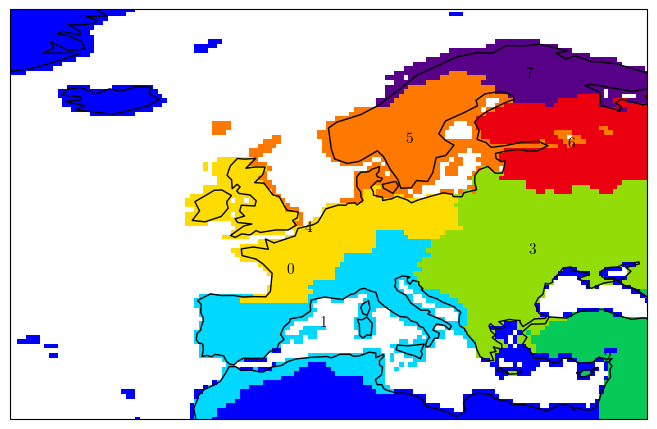

In [3]:
clu = Clusterplot(1, 1, exp_T.region)
cmap = colormaps.BlAqGrYeOrReVi200
ax = clu.axes[0]
unique_clusters = np.arange(n_clu)
norm = BoundaryNorm(np.concatenate([[-1], unique_clusters]) + 0.5, cmap.N)
clusters_da.unstack().plot(
    ax=ax,
    cmap=cmap,
    norm=norm,
    add_colorbar=False,
    add_labels=False
)
for j in range(n_clu):
    lo = clusters_da.lon.where(clusters_da==j).mean().item()
    la = clusters_da.lat.where(clusters_da==j).mean().item()
    ax.text(lo, la, f"${j}$", ha="center", va="center", fontweight="bold")
    
plt.savefig(f"{FIGURES}/jet_props_hot/centers.png")

# Prediction tasks

## Half van straaten

In [ ]:
import warnings
warnings.filterwarnings("error")
predictors = prepare_predictors(
    props_as_ds,
    subset=subset,
    anomalize=True,
    normalize=True,
    detrend=True,
    nan_method="nearest",
    season="JJA",
    lags=[0, 4, 8, 16],
)

full_pred, feature_importances, raw_shap = exp_T.full_prediction(
    predictors,
    create_target_kwargs=create_targets_kwargs,
    type_="rf",
    do_base_pred=True,
    prediction_kwargs=dict(
        max_depth=11,
        n_estimators=1000,
    )
)

  0%|          | 0/32 [00:00<?, ?it/s]

: 

In [ ]:
for key, rs in raw_shap.items():
    rs.feature_names = predictors.predictor.values
    raw_shap[key] = rs

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


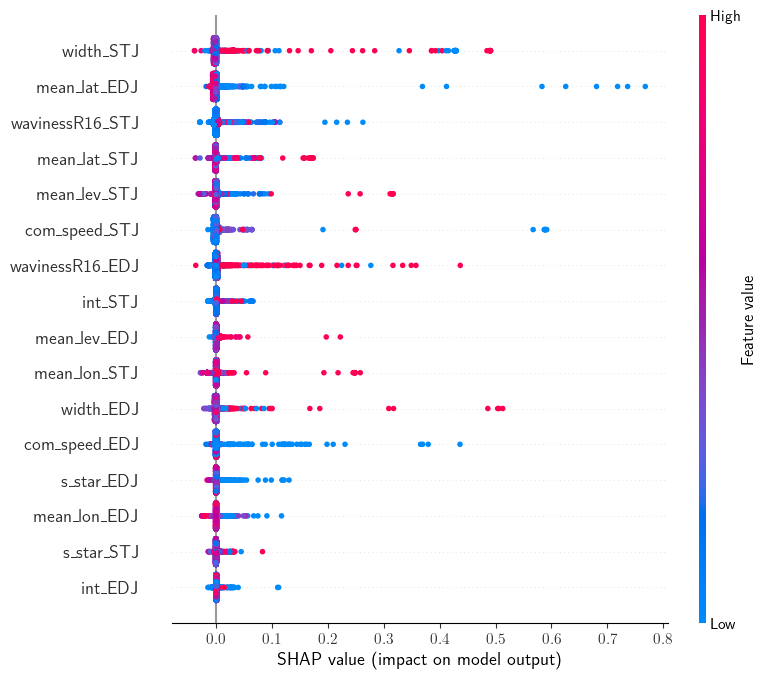

In [ ]:
from fasttreeshap import plots as ftpplots
# ftpplots.waterfall(raw_shap['region=4_lag=0'][0])
ftpplots.beeswarm(raw_shap['region=4_lag=0'], max_display=20)

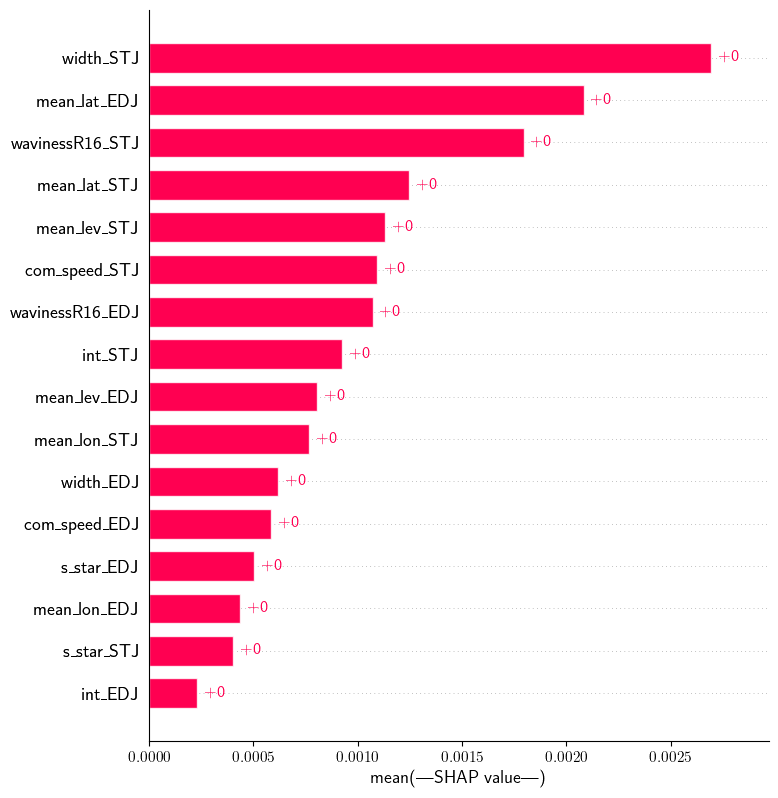

In [ ]:
ftpplots.bar(raw_shap['region=4_lag=0'], max_display=20)

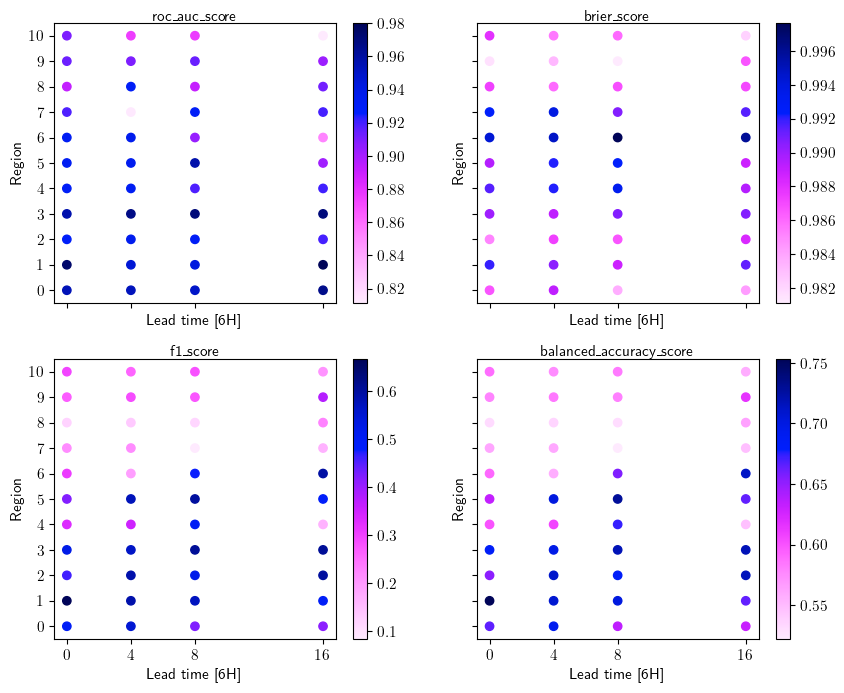

In [ ]:
x = full_pred.lag.values
y = full_pred.region.values
s = {
    "roc_auc_score": full_pred.roc_auc_score.values,
    "brier_score": full_pred.brier_score.values,
    "f1_score": full_pred.f1_score.values,
    "balanced_accuracy_score": full_pred.balanced_accuracy_score.values,
}
cmap = colormaps.cet_l_bmw1_r
fig, axes = plt.subplots(2, len(s) // 2, figsize=(10, 8), sharex="all", sharey="all")
for (scorename, s_), ax in zip(s.items(), axes.ravel()):
    im = ax.scatter(*np.meshgrid(x, y), c=s_.ravel(), cmap=cmap)
    ax.set_title(scorename)
    ax.set_xlabel("Lead time [6H]")
    ax.set_xticks(np.unique(x))
    _ = ax.set_ylabel("Region")
    _ = ax.set_yticks(np.unique(y))
    fig.colorbar(im, ax=ax)

In [ ]:
predictors.predictor

<xarray.DataArray 'predictor' (predictor: 16)> Size: 960B
array(['mean_lon_EDJ', 'mean_lon_STJ', 'mean_lat_EDJ', 'mean_lat_STJ',
       'mean_lev_EDJ', 'mean_lev_STJ', 's_star_EDJ', 's_star_STJ', 'width_EDJ',
       'width_STJ', 'wavinessR16_EDJ', 'wavinessR16_STJ', 'com_speed_EDJ',
       'com_speed_STJ', 'int_EDJ', 'int_STJ'], dtype='<U15')
Coordinates:
  * predictor  (predictor) <U15 960B 'mean_lon_EDJ' 'mean_lon_STJ' ... 'int_STJ'
    varname    (predictor) object 128B 'mean_lon' 'mean_lon' ... 'int' 'int'
    jet        (predictor) object 128B 'EDJ' 'STJ' 'EDJ' ... 'STJ' 'EDJ' 'STJ'

invalid value encountered in sqrt
invalid value encountered in sqrt
invalid value encountered in sqrt
invalid value encountered in sqrt
invalid value encountered in sqrt


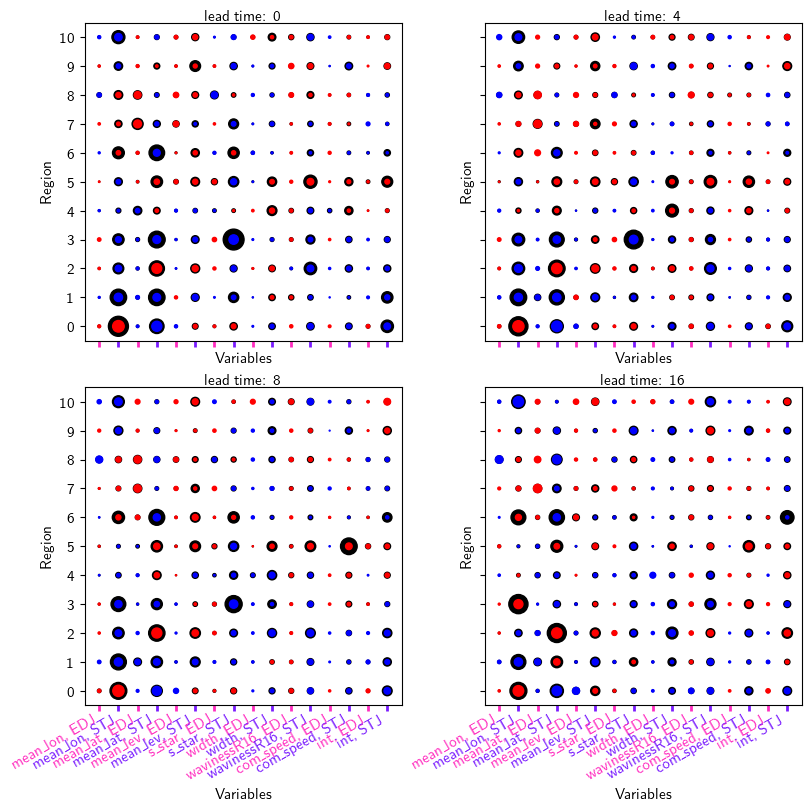

In [ ]:
varnames, index_ = np.unique(predictors.varname.values, return_index=True)
varnames = varnames[np.argsort(index_)]
jets, index_ = np.unique(predictors.jet.values, return_index=True)
jets = jets[np.argsort(index_)]

lead_times = predictors.lag.values
regions = feature_importances.region.values
x = np.arange(len(varnames) * len(jets))
y = np.arange(len(regions))
meshgrid = np.meshgrid(x, y)
fig, axes = plt.subplots(2, 2, figsize=(8, 8), constrained_layout=True, sharey='all', sharex="all")

for ax, lead_time in zip(axes.ravel(), lead_times):
    s1 = feature_importances.loc["permutation", :, :, lead_time]
    s2 = feature_importances.loc["mean_abs_shap", :, :, lead_time]
    c = feature_importances.loc["correlation", :, :, lead_time]
    s1 = s1.values.reshape(len(x), len(y))
    s2 = s2.values.reshape(len(x), len(y))
    c = np.sign(c.values.reshape(len(x), len(y)))
    x = np.arange(s1.shape[0])
    y = np.arange(s1.shape[1])
    ax.scatter(*meshgrid, s=s1.T * 500, color='black')#, vmin=vmin, vmax=vmax, cmap=colormaps.cet_l_bmw)
    ax.scatter(*np.meshgrid(x, y), s=s2.T * 5000, c=np.sign(c).T, cmap='bwr', vmin=-1, vmax=1)
    ax.set_xlabel('Variables')
    xticks = ax.set_xticks(np.unique(x), [f"{varname}, {jet}" for varname in varnames for jet in jets], rotation=30, ha="right")
    ax.set_ylabel('Region')
    ax.set_yticks(y, regions)
    ax.set_title(f'lead time: {lead_time}')
    ax.tick_params(axis="x", length=4, width=2, pad=1)
    for i, tick in enumerate(xticks):
        tick._apply_params(color=COLORS[1 + (i + 1) % 2], labelcolor=COLORS[1 + (i + 1) % 2])
# plt.savefig(f"{figure_subfolder}/vanstraaten_importance.png")

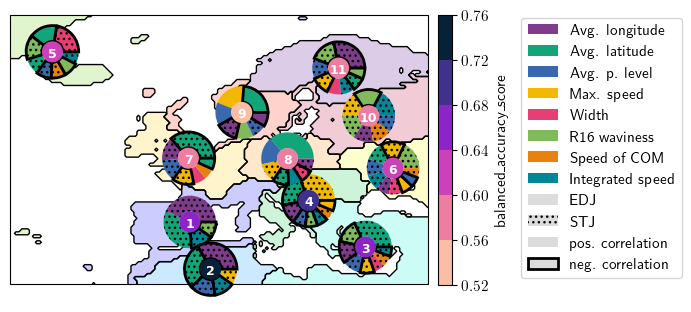

In [ ]:
from matplotlib.patches import Patch
from matplotlib.ticker import MaxNLocator
lon, lat = clusters_da.lon.values, clusters_da.lat.values
type_ = "mean_abs_shap"
score_name = "balanced_accuracy_score"
lag = 0

def assign_to_regions(clusters_da, arr):
    to_ret = clusters_da.copy()
    for i, val in enumerate(arr):
        to_ret = to_ret.where(to_ret != i, val)
    return to_ret 

clu = Clusterplot(1, 1, get_region(clusters_da), coastline=False)
ax0 = clu.axes[0]
cmap = colormaps.BlAqGrYeOrReVi200
unique_clusters = np.arange(n_clu)
norm = BoundaryNorm(np.concatenate([[-1], unique_clusters]) + 0.5, cmap.N)
clusters_da = exp_T.spatial_clusters_as_da(n_clu)
clusters_da.unstack().plot(
    ax=ax0,
    # colors="gainsboro", 
    # levels=[0.99, 1.5],
    cmap=cmap,
    norm=norm,
    add_colorbar=False,
    add_labels=False,
    alpha=0.2
)

to_plot = full_pred.sel(lag=lag)[score_name].values
to_plot = assign_to_regions(clusters_da, to_plot)
cmap_score = colormaps.bubblegum_r
levels = MaxNLocator(6).tick_values(to_plot.min(), to_plot.max())
cbar_kwargs = {"shrink": 0.84, "label": score_name, "pad": 0.02}
norm_score = BoundaryNorm(levels, cmap_score.N)
clu.fig.colorbar(ScalarMappable(norm_score, cmap_score), ax=ax0, **cbar_kwargs)

all_preds = np.arange(len(predictors.predictor))
cmap = colormaps.bold
norm = BoundaryNorm(np.arange(cmap.N) - 0.5, cmap.N)
colors = cmap(norm(all_preds // 2))
colors = pd.Series(dict(zip(predictors.predictor.values, colors)))
hatchstyle1 = np.asarray(["", "..."])
hatchstyle2 = np.asarray(["", ".."])
hatches = hatchstyle1[all_preds % 2]
hatches = pd.Series(dict(zip(predictors.predictor.values, hatches)))
dx, dy = 11, 11
size = 0.6
explode = 0.0
radius = 1.
pie_kwargs1 = {
    "wedgeprops": dict(width=size),
    "radius": radius,
}
pie_kwargs2 = {
    "wedgeprops": dict(zorder=3),
    "radius": radius * (1.0 + explode - size),
}
patch = dict(boxstyle='round', facecolor='white', alpha=1.0)
for n, (pred, to_app) in enumerate(zip(full_pred.sel(lag=lag).transpose("region", ...), feature_importances.sel(lag=lag).transpose("region", ...))):
    lo = clusters_da.lon.where(clusters_da==n).mean().item()
    la = clusters_da.lat.where(clusters_da==n).mean().item()
    # ax0.contourf(lon, lat, (clusters_da == n).astype(int), colors="gainsboro", levels=[0.99, 1.5], zorder=10, transform=ccrs.PlateCarree())
    a = ax0.contour(lon, lat, (clusters_da == n).astype(int), colors="black", levels=[0.5], zorder=10, linewidths=1, transform=ccrs.PlateCarree())
    ax0.text(lo, la, f"{n + 1}", ha="center", va="center_baseline", ma="center", fontweight="bold", color="white", zorder=14, usetex=False, fontsize=9)
    pathpatch = a.get_paths()[0].to_polygons()[0] # TODO: Need to resize and center
    thisax = ax0.inset_axes([lo - dx / 2, la - dy / 2, dx, dy], transform=ax0.transData, zorder=13)
    score = pred[score_name]
    keys = to_app.predictor.values
    asdict = pd.Series(dict(zip(keys, to_app.sel(type=type_).values))).sort_values(ascending=False) # probably the problem
    is_neg = to_app.sel(type="correlation").values < 0
    keys = asdict.index.tolist()
    colors_ = colors.loc[keys].values
    hatches_ = hatches.loc[keys].values
    hatches_ = hatches_
    pred_imp_ = np.clip(asdict.values, 0, None)
    mask_ = (pred_imp_ / pred_imp_.sum()) > 0.05
    patches = thisax.pie(pred_imp_[mask_], explode=len(pred_imp_[mask_]) * [explode], colors=colors_[mask_], hatch=hatches_[mask_], **pie_kwargs1)[0]
    for patch, is_neg_ in zip(patches, is_neg[mask_]):
        if is_neg_:
            patch.set_linewidth(2)
            patch.set_edgecolor("k")
            patch.set_zorder(2)
    thisax.pie([1.], colors=[cmap_score(norm_score(score))], **pie_kwargs2)
    
legend_elements = [
    Patch(facecolor=cmap(norm(i)), edgecolor="black", label=PRETTIER_VARNAME[varname], linewidth=0) for i, varname in enumerate(subset)
]
jets = props_as_ds.jet.values
legend_elements.extend([
    Patch(edgecolor="black", facecolor="gainsboro", label=jet, hatch=hatch, linewidth=0) for jet, hatch in zip(jets, hatchstyle1)
])
legend_elements.extend([
    Patch(edgecolor="black", facecolor="gainsboro", label=sign_, linewidth=linewidth) for sign_, linewidth in zip(["pos. correlation", "neg. correlation"], [0, 2])
])
clu.fig.legend(handles=legend_elements, loc="center left", bbox_to_anchor=(0.9, 0.5))
clu.fig.set_tight_layout(False)
plt.savefig(f"{figure_subfolder}/predictor_importance_{type_}_lag={lag}.png")
clear_output()

In [ ]:
varnames = predictors.varname.values[::6]
jets = predictors.jet.values[[0, 3]]
feature_timscales = np.unique(predictors.timescale.values)
lead_times = predictors.lag.values
regions = feature_importances.region.values
x = np.arange(len(varnames) * len(jets))
y = np.arange(len(feature_timscales))
meshgrid = np.meshgrid(x, y)
fig, axes = plt.subplots(2, 2, figsize=(8, 8), constrained_layout=True, sharey='all', sharex="all")
region = 6

for ax, lead_time in zip(axes.ravel(), lead_times):
    s1 = feature_importances.loc["permutation", :, region, lead_time]
    s2 = feature_importances.loc["mean_abs_shap", :, region, lead_time]
    c = feature_importances.loc["correlation", :, region, lead_time]
    s1 = s1.values.reshape(len(x), len(y))
    s2 = s2.values.reshape(len(x), len(y))
    c = np.sign(c.values.reshape(len(x), len(y)))
    x = np.arange(s1.shape[0])
    y = np.arange(s1.shape[1])
    ax.scatter(*meshgrid, s=s1.T * 2000, color='black')#, vmin=vmin, vmax=vmax, cmap=colormaps.cet_l_bmw)
    ax.scatter(*np.meshgrid(x, y), s=s2.T * 5000, c=np.sign(c).T, cmap='bwr', vmin=-1, vmax=1)
    ax.set_xlabel('Variables')
    xticks = ax.set_xticks(np.unique(x), [f"{varname}, {SHORTHAND[jet][0]}" for varname in varnames for jet in jets], rotation=30, ha="right")
    ax.set_ylabel('Feature timescale')
    ax.set_yticks(y, feature_timscales)
    ax.set_title(f'lead time: {lead_time}, region: {region}')
    ax.tick_params(axis="x", length=4, width=2, pad=1)
    for i, tick in enumerate(xticks):
        tick._apply_params(color=COLORS[1 + (i + 1) % 2], labelcolor=COLORS[1 + (i + 1) % 2])
# plt.savefig(f"{figure_subfolder}/vanstraaten_importance.png")

In [ ]:
s1.sum()

2.6459853311379753

## cv

In [ ]:
targets_folder = path.parent.parent
targets = xr.open_dataarray(targets_folder.joinpath("length_targets.nc")) > 0
metadata = load_pickle(path.joinpath("metadata.pkl"))
type_ = metadata["type"]
path_to_base_pred = metadata["base_pred"]
prediction_kwargs = None
if prediction_kwargs is None:
    prediction_kwargs = metadata["prediction_kwargs"]
if prediction_kwargs is None:
    prediction_kwargs = {}
if path_to_base_pred is not None:
    base_pred = xr.open_dataarray(path_to_base_pred)
else:
    base_pred = None
best_predictors = load_pickle(path.joinpath("best_predictors.pkl"))
combination = {}
for identifier, predictor_list in tqdm(best_predictors.items()):
    thispath = path.joinpath(identifier)
    full_pred_fn = thispath.joinpath("full_pred_best.nc")
    feature_importances_fn = thispath.joinpath("feature_importances_best.nc")
    raw_shap_fn = thispath.joinpath("raw_shap.pkl")
    if all(
        [
            fn.is_file()
            for fn in [full_pred_fn, feature_importances_fn, raw_shap_fn]
        ]
    ):
        full_pred = xr.open_dataarray(full_pred_fn)
        feature_importances = xr.open_dataarray(feature_importances_fn)
        raw_shap = load_pickle(raw_shap_fn)
        combination[identifier] = (full_pred, feature_importances, raw_shap)
        continue
    indexer_list = identifier.split("_")
    indexer = {}
    for indexer_ in indexer_list:
        dim, val = indexer_.split("=")
        try:
            val = float(val)
        except ValueError:
            pass
        indexer[dim] = val
    if base_pred is None:
        base_pred_ = None
    else:
        base_pred_ = base_pred.loc[indexer].squeeze()
    targets_ = targets.loc[indexer].squeeze()
    predictors_ = predictors.sel(predictor=predictor_list)

In [ ]:
import xgboost as xgb
from tqdm.contrib.itertools import product as tropduct
X = predictors_.drop_vars(
    ["varname", "jet", "timescale"], errors="ignore"
).to_pandas()
y_base = base_pred_.transpose("time", ...)
y_orig = targets_
y = y_orig - y_base
y = y.to_pandas()
y_orig = y_orig.to_pandas()
y_base = y_base.to_pandas()

cv_params = dict(
    max_depth=[7, 11, 15],
    min_samples_split=[40],
    max_features=[10],
    n_estimators=[1000, 1500, 2500],
    fold=np.arange(5),
)
da_template = xr.DataArray(np.zeros([len(c) for c in cv_params.values()]), coords=cv_params)
scores_ds = xr.Dataset({name: da_template.copy() for name in ALL_SCORES})
for params in tropduct(*cv_params.values()):
    train_kwargs = dict(
        max_depth=params[0],
        min_samples_split=params[1],
        max_features=params[2],
        n_estimators=params[3],
    )
    X_train, X_test, y_train, y_test, _, y_orig_test, _, y_base_test = (
        train_test_split(X, y, y_orig, y_base, test_size=0.2)
    )
    model = RandomForestRegressor(n_jobs=N_WORKERS, **train_kwargs).fit(
        X_train, y_train
    )
    y_pred_prob = model.predict(X_test) + y_base_test
    y_pred_prob = np.clip(y_pred_prob, 0, 1)
    y_pred = y_pred_prob > 0.5
    scores = compute_all_scores(y_orig_test, y_pred, y_pred_prob)
    indexer = dict(fold=params[-1], **train_kwargs)
    for scorename, score in scores.items():
        scores_ds[scorename].loc[indexer] = score
    break

In [ ]:
scores_ds.to_netcdf(path.joinpath("scores_ds.nc"))

In [ ]:
scores_ds = xr.open_dataset(path.joinpath("scores_ds.nc"))

In [ ]:
fig, axes = plt.subplots(2, 2, figsize=(8, 7), tight_layout=True)
for score, ax in zip(ALL_SCORES, axes.ravel()):
    scores_ds[score].squeeze().mean("fold").plot(ax=ax)

## Multi combination regression like García-Burgos

In [ ]:
best_combinations, best_combination, path = exp_T.multi_combination_prediction(
    predictors,
    create_target_kwargs=dict(n_clu=n_clu),
    type_="rf",
    do_base_pred=True,
    max_n_predictors=10,
    winner_according_to="roc_auc_score",
)

In [ ]:
best_combination = exp_T.best_combination_prediction(
    predictors,
    path,
    prediction_kwargs=dict(
        max_depth=11,
        min_samples_split=40,
        max_features=10,
        n_estimators=1500,
    )
)

In [ ]:
max_n_predictors = len(best_combinations["region=1"]) + 1
n_clu = len(best_combinations)
cmap = colormaps.BlAqGrYeOrReVi200
norm = BoundaryNorm(np.concatenate([[-1], np.arange(n_clu)]) + 0.5, cmap.N)
colors = cmap(norm(np.arange(n_clu)))
x = np.arange(1, max_n_predictors)
fig, axes = plt.subplots(2, 2, figsize=(10, 10), sharex="all", sharey="all")
all_scores = []
for (regionkey, best_combinations_), color in zip(best_combinations.items(), colors):
    ri = int(regionkey.split("=")[-1])
    df = []
    for n in x:
        bcs = best_combinations_[n][0]
        df.append({scorekey: bcs[scorekey].item() for scorekey in ALL_SCORES})
    df = pd.DataFrame(df)
    all_scores.append(df)
    for ax, sn in zip(axes.ravel(), df):
        series = df[sn]
        ax.plot(x, series.values, label=ri, lw=2, color=color)
for i, (ax, title) in enumerate(zip(axes.ravel(), ALL_SCORES)):
    ax.set_xlabel("predictors")
    ax.set_ylabel(title)
axes.ravel()[0].legend(ncol=4)
plt.savefig(f"{figure_subfolder}/prediction_skills.png")

In [ ]:
from matplotlib.ticker import MaxNLocator
lon, lat = clusters_da.lon.values, clusters_da.lat.values

def assign_to_regions(clusters_da, arr):
    to_ret = clusters_da.copy()
    for i, val in enumerate(arr):
        to_ret = to_ret.where(to_ret != i, val)
    return to_ret 

best_scores = pd.DataFrame([{score_name: combination[0][score_name].item() for score_name in ALL_SCORES} for combination in best_combination.values()]).values.T
clu = Clusterplot(2, 2, exp_T.region)

for to_plot_, title, ax in zip(best_scores, ALL_SCORES, clu.axes):
    to_plot = assign_to_regions(clusters_da, to_plot_)
    cmap = colormaps.bubblegum_r
    levels = MaxNLocator(6).tick_values(to_plot.min(), to_plot.max())
    cbar_kwargs = {"shrink": 0.85}
    norm = BoundaryNorm(levels, cmap.N)
    to_plot.plot(ax=ax, cmap=cmap, norm=norm, add_colorbar=True, cbar_kwargs=cbar_kwargs, add_labels=False)
    ax.set_title(title)
    for n in range(n_clu):
        ax.contour(lon, lat, (clusters_da == n).astype(int), colors="white", levels=[0.5], zorder=200, linewidths=1, transform=ccrs.PlateCarree())
        lo = clusters_da.lon.where(clusters_da==n).mean().item()
        la = clusters_da.lat.where(clusters_da==n).mean().item()
        ax.text(lo, la, f"${n}$", ha="center", va="center", fontweight="bold", color="white")
plt.savefig(f"{figure_subfolder}/prediction_skill_map.png")

In [ ]:
from matplotlib.patches import Patch
from matplotlib.ticker import MaxNLocator
lon, lat = clusters_da.lon.values, clusters_da.lat.values
type_ = "mean_abs_shap"

def assign_to_regions(clusters_da, arr):
    to_ret = clusters_da.copy()
    for i, val in enumerate(arr):
        to_ret = to_ret.where(to_ret != i, val)
    return to_ret 

clu = Clusterplot(1, 1, get_region(clusters_da), coastline=False)
ax0 = clu.axes[0]
cmap = colormaps.BlAqGrYeOrReVi200
unique_clusters = np.arange(n_clu)
norm = BoundaryNorm(np.concatenate([[-1], unique_clusters]) + 0.5, cmap.N)
clusters_da = exp_T.spatial_clusters_as_da(n_clu)
clusters_da.unstack().plot(
    ax=ax0,
    # colors="gainsboro", 
    # levels=[0.99, 1.5],
    cmap=cmap,
    norm=norm,
    add_colorbar=False,
    add_labels=False,
    alpha=0.2
)

score_name = "balanced_accuracy_score"
to_plot = [combination[0][score_name].item() for combination in best_combination.values()]
to_plot = assign_to_regions(clusters_da, to_plot)
cmap_score = colormaps.bubblegum_r
levels = MaxNLocator(6).tick_values(to_plot.min(), to_plot.max())
cbar_kwargs = {"shrink": 0.84, "label": score_name, "pad": 0.02}
norm_score = BoundaryNorm(levels, cmap_score.N)
clu.fig.colorbar(ScalarMappable(norm_score, cmap_score), ax=ax0, **cbar_kwargs)

all_preds = np.arange(len(predictors.predictor))
cmap = colormaps.bold
norm = BoundaryNorm(np.arange(cmap.N) - 0.5, cmap.N)
colors = cmap(norm(all_preds // 2))
colors = pd.Series(dict(zip(predictors.predictor.values, colors)))
hatchstyle1 = np.asarray(["", "..."])
hatchstyle2 = np.asarray(["", ".."])
hatches = hatchstyle1[all_preds % 2]
hatches = pd.Series(dict(zip(predictors.predictor.values, hatches)))
dx, dy = 11, 11
size = 0.6
explode = 0.0
radius = 1.
pie_kwargs1 = {
    "wedgeprops": dict(width=size),
    "radius": radius,
}
pie_kwargs2 = {
    "wedgeprops": dict(zorder=3),
    "radius": radius * (1.0 + explode - size),
}
patch = dict(boxstyle='round', facecolor='white', alpha=1.0)
for regionkey, combination in best_combination.items():
    n = int(regionkey.split("=")[-1])
    lo = clusters_da.lon.where(clusters_da==n).mean().item()
    la = clusters_da.lat.where(clusters_da==n).mean().item()
    # ax0.contourf(lon, lat, (clusters_da == n).astype(int), colors="gainsboro", levels=[0.99, 1.5], zorder=10, transform=ccrs.PlateCarree())
    a = ax0.contour(lon, lat, (clusters_da == n).astype(int), colors="black", levels=[0.5], zorder=10, linewidths=1, transform=ccrs.PlateCarree())
    ax0.text(lo, la, f"{n + 1}", ha="center", va="center_baseline", ma="center", fontweight="bold", color="white", zorder=14, usetex=False, fontsize=9)
    pathpatch = a.get_paths()[0].to_polygons()[0] # TODO: Need to resize and center
    thisax = ax0.inset_axes([lo - dx / 2, la - dy / 2, dx, dy], transform=ax0.transData, zorder=13)
    score = combination[0][score_name]
    to_app = combination[1]
    keys = combination[1].predictor.values
    asdict = pd.Series(dict(zip(keys, to_app.sel(type=type_).values))).sort_values(ascending=False)
    is_neg = to_app.sel(type="correlation").values < 0
    colors_ = colors.loc[keys].values
    hatches_ = hatches.loc[keys].values
    hatches_ = hatches_
    pred_imp_ = np.clip(asdict.values, 0, None)
    patches = thisax.pie(pred_imp_, explode=len(pred_imp_) * [explode], colors=colors_, hatch=hatches_, **pie_kwargs1)[0]
    for patch, is_neg_ in zip(patches, is_neg):
        if is_neg_:
            patch.set_linewidth(2)
            patch.set_edgecolor("k")
            patch.set_zorder(2)
    thisax.pie([1.], colors=[cmap_score(norm_score(score))], **pie_kwargs2)
    
legend_elements = [
    Patch(facecolor=cmap(norm(i)), edgecolor="black", label=PRETTIER_VARNAME[varname], linewidth=0) for i, varname in enumerate(subset)
]
jets = props_as_ds.jet.values
legend_elements.extend([
    Patch(edgecolor="black", facecolor="gainsboro", label=SHORTHAND[jet], hatch=hatch, linewidth=0) for jet, hatch in zip(jets, hatchstyle1)
])
legend_elements.extend([
    Patch(edgecolor="black", facecolor="gainsboro", label=sign_, linewidth=linewidth) for sign_, linewidth in zip(["pos. correlation", "neg. correlation"], [0, 2])
])
clu.fig.legend(handles=legend_elements, loc="center left", bbox_to_anchor=(0.9, 0.5))
clu.fig.set_tight_layout(False)
plt.savefig(f"{figure_subfolder}/predictor_importance_{type_}.png")
clear_output()

# Aggregates around hws

In [10]:
predictors = prepare_predictors(
    props_as_ds,
    subset=subset,
    anomalize=True,
    normalize=True,
    detrend=True,
    nan_method="nearest",
    season="JJA",
)
targets, length_targets, all_spells_ts, all_spells = exp_T.create_targets(**create_targets_kwargs)
binary_targets = length_targets > 0
masked_predictors = mask_from_spells_multi_region(predictors, targets, all_spells_ts, all_spells, time_before=time_before)

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

## Jet indice terciles at onset of heatwaves at region $R$

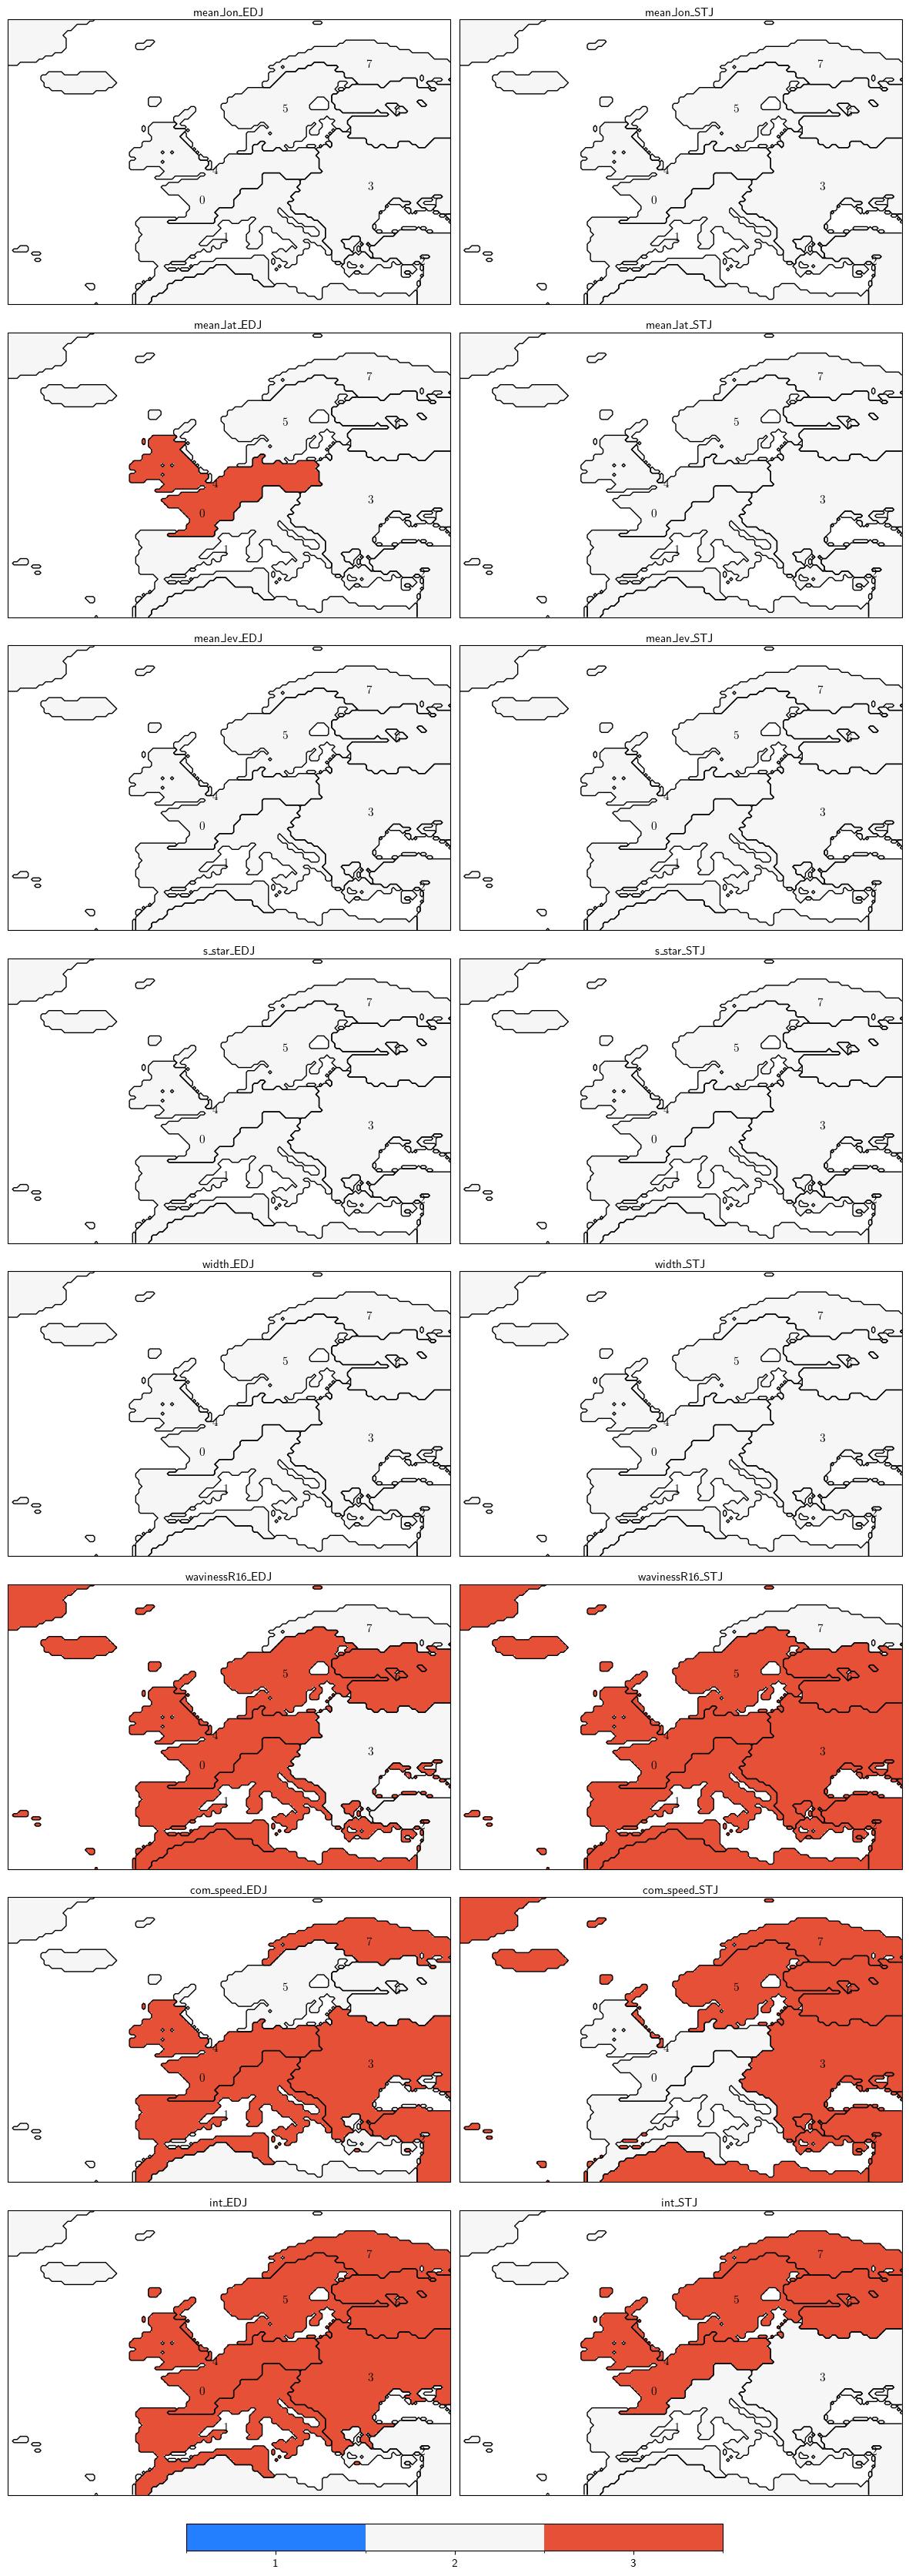

In [19]:
quantiles = predictors.quantile([0.33, 0.66], dim="time")
lon, lat = clusters_da.lon.values, clusters_da.lat.values
hw_means = masked_predictors.sel(time_around_beg=[np.timedelta64(i * 6, "h") for i in range(-1, 2)]).mean(dim=["spell", "time_around_beg"])
predictor_names = masked_predictors.predictor.values
to_plot = []
for hw_mean, quantile in zip(hw_means.transpose("predictor", ...), quantiles.transpose("predictor", ...)):
    vals = np.digitize(hw_mean, quantile)
    to_plot_ = clusters_da.copy()
    for n, val in zip(hw_mean.region.values, vals):
        to_plot_ = to_plot_.where(clusters_da != n, val)
    to_plot.append(to_plot_)
clu = Clusterplot(len(hw_means.predictor) // 2, 2, exp_T.region, coastline=False)
cmap = colormaps.cet_d_bwr
norm = BoundaryNorm(np.arange(-0.5, 3.5), cmap.N)
cbar = clu.fig.colorbar(ScalarMappable(norm, cmap), ax=clu.axes, shrink=0.6, orientation="horizontal", pad=0.01)
cbar.ax.set_xticks([0, 1, 2], labels=['1', '2', '3'])
for ax, predictor_name, to_plot_ in zip(clu.axes.ravel(), predictor_names, to_plot):
    to_plot_.plot(ax=ax, cmap=cmap, norm=norm, add_colorbar=False, add_labels=False)
    ax.set_title(predictor_name, pad=4)
    for n in range(n_clu):
        ax.contour(lon, lat, (clusters_da == n).astype(int), colors="black", levels=[0.5], zorder=200, linewidths=1, transform=ccrs.PlateCarree())
        lo = clusters_da.lon.where(clusters_da==n).mean().item()
        la = clusters_da.lat.where(clusters_da==n).mean().item()
        ax.text(lo, la, f"${n}$", ha="center", va="center", fontweight="bold", color="black")
clu.resize_relative([0.9, 1.0])
plt.savefig(f"{figure_subfolder}/jet_props_quantiles.png")
# clear_output()

## Jet index anoms around hws

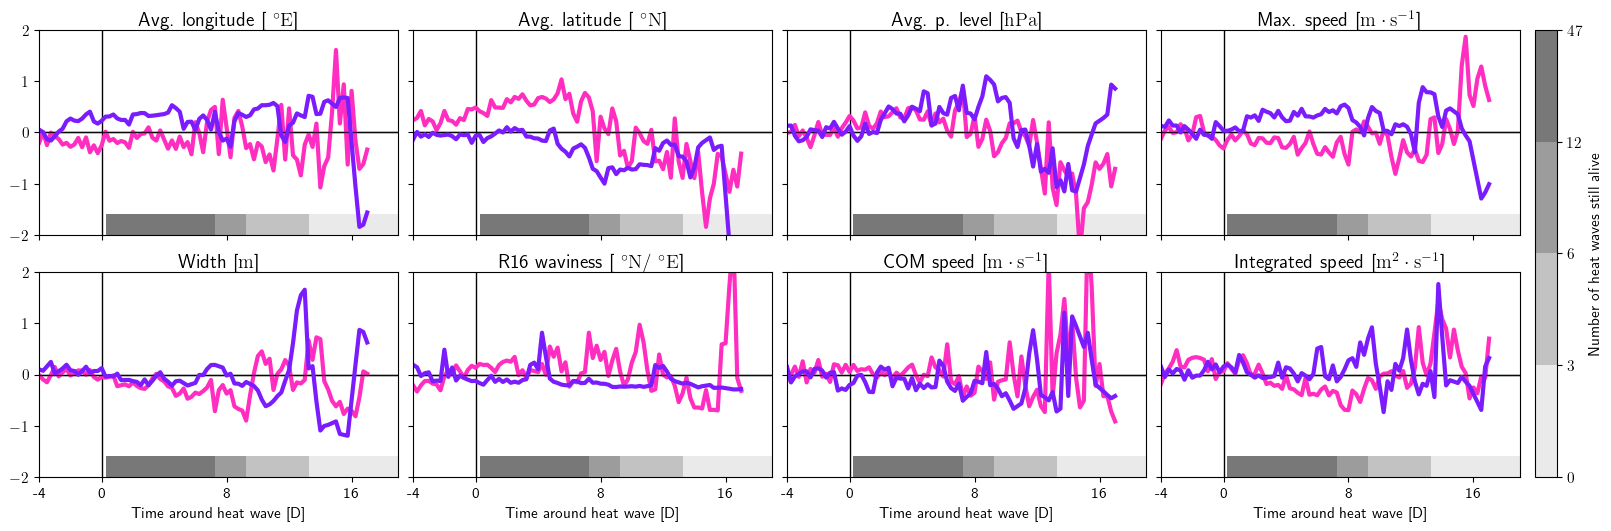

In [20]:
data_vars = subset

fig, axes = plt.subplots(
    2,
    4,
    figsize=(16, len(data_vars) // 4 * 2.6),
    constrained_layout=True,
    sharex="all",
    sharey="all"
)
axes = np.atleast_2d(axes)
months = np.unique(predictors.time.dt.month.values)
months = [str(months[0]).zfill(2), str(min(12, months[-1] + 1)).zfill(2)]
region = 4
heat_waves_ts, heat_waves = all_spells_ts[region], all_spells[region]
lengths = heat_waves[:, 1] - heat_waves[:, 0]
longest_hotspell = np.argmax(lengths)
time_around_beg = heat_waves_ts[longest_hotspell] - heat_waves[longest_hotspell, 0]
dt = (predictors.time.values[1] - predictors.time.values[0]).astype("timedelta64[h]")
props_as_ds_masked = masked_predictors.sel(region=region)
colors = COLORS[2:0:-1]
n_hotspell = 1
x = masked_predictors.time_around_beg.values.astype("timedelta64[h]")
for varname, ax in zip(data_vars, axes.ravel()):
    for j, jet in enumerate(np.unique(props_as_ds_masked.jet.values)):
        predictor = f"{varname}_{jet}"
        this_da = props_as_ds_masked.sel(predictor=predictor)
        with warnings.catch_warnings():
            warnings.simplefilter("ignore")
            mean = this_da.mean(dim="spell").values
        ax.plot(x, [0] * len(x), color="black", alpha=0.8, lw=1)
        ax.plot(x, mean, color=colors[j], lw=3, ls="solid")
                
positive_mask = x.astype(int) > 0
alive_hotspells = (~this_da[:, positive_mask].isnull()).sum(dim="spell").values
cmap = colormaps.cet_l_grey_r
cmap = LinearSegmentedColormap.from_list(
    "mod_grey", 
    cmap(np.linspace(0.1, 0.73, 200)), N=200
)
norm = BoundaryNorm([0, 3, 6, 12, alive_hotspells.max()], cmap.N)
indices = [0] + np.arange(16, len(x), 32).tolist()
ticks = x[indices].astype(int)
xlim = np.amin(x.astype(float)), 19 * 24
ticklabels = x.astype("timedelta64[D]").astype(int)[indices]
for varname, ax in zip(data_vars, axes.ravel()):
    ax.set_title(f"{PRETTIER_VARNAME[varname]} [{UNITS[varname]}]", fontsize=14)
    ylim = -2, 2
    ybounds = ylim[0] + np.asarray([0, 0.1 * (ylim[1] - ylim[0])])
    im = ax.pcolormesh(
        x.astype(float)[positive_mask], ybounds, alive_hotspells[None, :-1], zorder=-10, norm=norm,
        cmap=cmap, alpha=0.7
    )
    ax.set_xticks(ticks, ticklabels, ha="center")
    ax.set_xlim(xlim)
    ax.vlines(0, *ylim, color="black", lw=1, ls="solid", zorder=-10)
    ax.set_ylim(ylim)
cbar = fig.colorbar(im, ax=axes, pad=0.01)
_ = cbar.ax.set_ylabel("Number of heat waves still alive")
for ax in axes[-1, :]:
    ax.set_xlabel("Time around heat wave [D]")
plt.savefig(f'{FIGURES}/jet_props_hot/relative_series_rel_r{region}.png')

## Jet index around heat waves

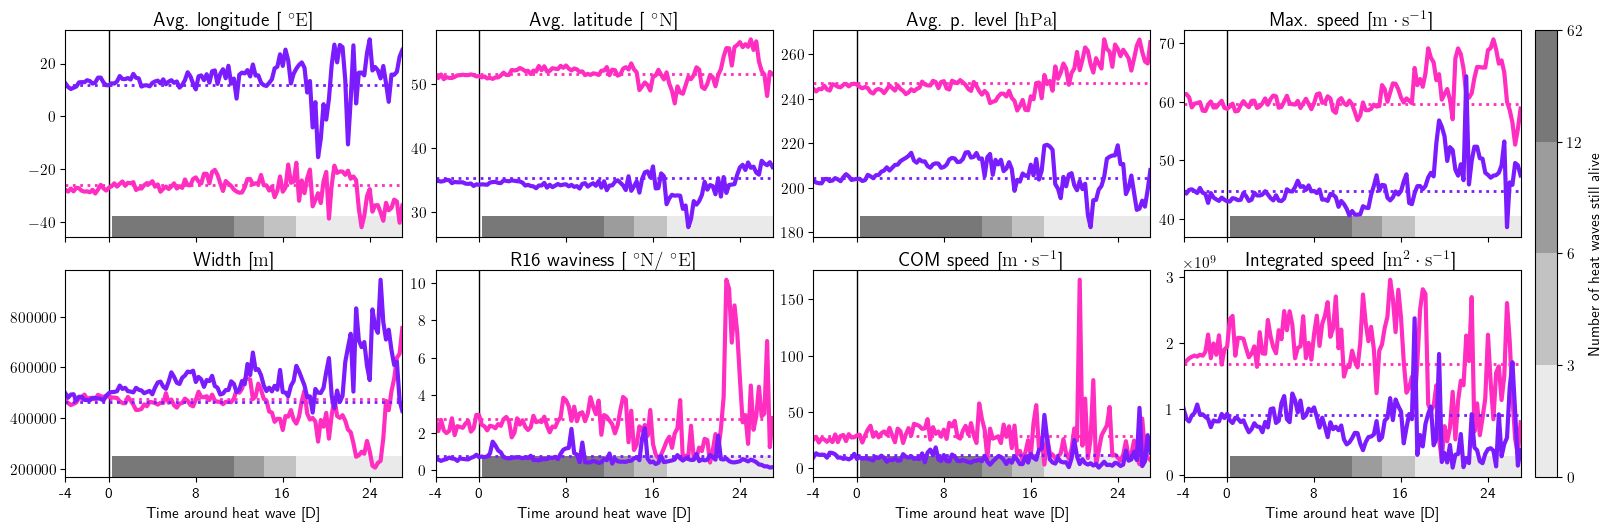

In [22]:
predictors = prepare_predictors(
    props_as_ds,
    subset=subset,
    anomalize=False,
    normalize=False,
    detrend=False,
    nan_method="nearest",
    season="JJA",
)
targets, length_targets, all_spells_ts, all_spells = exp_T.create_targets(**create_targets_kwargs)
binary_targets = length_targets > 0
masked_predictors = mask_from_spells_multi_region(predictors, targets, all_spells_ts, all_spells, time_before=time_before)

fig, axes = plt.subplots(
    2,
    4,
    figsize=(16, len(data_vars) // 4 * 2.6),
    constrained_layout=True,
    sharex='all'
)
region = 1
heat_waves_ts, heat_waves = all_spells_ts[region], all_spells[region]
months = np.unique(props_as_ds.time.dt.month.values)
months = [str(months[0]).zfill(2), str(min(12, months[-1] + 1)).zfill(2)]
lengths = heat_waves[:, 1] - heat_waves[:, 0]
longest_hotspell = np.argmax(lengths)
time_around_beg = heat_waves_ts[longest_hotspell] - heat_waves[longest_hotspell, 0]
dt = (props_as_ds.time.values[1] - props_as_ds.time.values[0]).astype('timedelta64[h]')
colors = COLORS[2:0:-1]
n_hotspell = 1
props_as_ds_masked = masked_predictors.sel(region=region)
x = props_as_ds_masked.time_around_beg.values.astype('timedelta64[h]')
for varname, ax in zip(data_vars, axes.ravel()):
    for j, jet in enumerate(np.unique(props_as_ds_masked.jet.values)):
        predictor = f"{varname}_{jet}"
        this_da = props_as_ds_masked.sel(predictor=predictor)
        with warnings.catch_warnings():
            warnings.simplefilter("ignore")
            mean = this_da.mean(dim='spell').values
        ax.plot(x, mean, color=colors[j], lw=3, ls='solid')
        mean_all = props_as_ds[varname].sel(jet=jet, time=props_as_ds.time.dt.season=="JJA").mean(dim='time').values
        ax.plot(x, [mean_all] * len(this_da.time_around_beg), color=colors[j], lw=2, ls='dotted')
from matplotlib.lines import Line2D

custom_lines = [
    Line2D([0], [0], color='black', lw=2, linestyle='solid', alpha=0.6),
    Line2D([0], [0], color='black', lw=3, linestyle='solid'),
    Line2D([0], [0], color='black', lw=2, linestyle='dotted'),
    Line2D([0], [0], color=colors[0], lw=3),
    Line2D([0], [0], color=colors[1], lw=3),
]
handles = [
    f'{props_as_ds_masked.absolute_time[n_hotspell, 0].dt.year.values} event', f'All heat waves', f'Mean of index',
    'Subtropical jet',
    'Polar jet'
]
positive_mask = x.astype(int) > 0
alive_hotspells = (~this_da[:, positive_mask].isnull()).sum(dim='spell').values
cmap = colormaps.cet_l_grey_r
cmap = LinearSegmentedColormap.from_list(
    'mod_grey', 
    cmap(np.linspace(0.1, 0.73, 200)), N=200
)
norm = BoundaryNorm([0, 3, 6, 12, alive_hotspells.max()], cmap.N)
indices = [0] + np.arange(16, len(x), 32).tolist()
ticks = x[indices].astype(int)
xlim = np.amin(x.astype(float)), np.amax(x.astype(float))
ticklabels = x.astype('timedelta64[D]').astype(int)[indices]
for varname, ax in zip(data_vars, axes.ravel()):
    ax.set_title(f'{PRETTIER_VARNAME[varname]} [{UNITS[varname]}]', fontsize=14)
    ylim = np.asarray(ax.get_ylim())
    ybounds = ylim[[0, 0]] + np.asarray([0, 0.1 * (ylim[1] - ylim[0])])
    im = ax.pcolormesh(
        x.astype(float)[positive_mask], ybounds, alive_hotspells[None, :-1], zorder=-10, norm=norm,
        cmap=cmap, alpha=0.7
    )
    ax.set_xlim(xlim)
    ax.set_xticks(ticks, ticklabels, ha='center')
    ax.vlines(0, *ylim, color='black', lw=1, ls='solid', zorder=-10)
    ax.set_ylim(ylim)
cbar = fig.colorbar(im, ax=axes, pad=0.01)
_ = cbar.ax.set_ylabel('Number of heat waves still alive')
for ax in axes[-1, :]:
    ax.set_xlabel('Time around heat wave [D]')
plt.savefig(f'{FIGURES}/jet_props_hot/relative_series_abs_r{region}.png')

## Jet position around heat waves

In [ ]:
jet_pos_da = jet_position_as_da(da, props_as_ds_uncat, all_jets_one_df, exp.path, processes=N_WORKERS, chunksize=100)

In [ ]:
da_jet_pos_masked = mask_from_t(da_cee, jet_pos_da, q=0.9, fill_holes=True, time_before=pd.Timedelta(4, 'D'))

In [ ]:
timesteps = np.arange(0, 32)
timesteps = np.arange(0, 32)
timesteps_ = np.split(timesteps, 8)
this_da = da_jet_pos_masked.mean(dim="heat_wave")
to_plot_subtropical = [this_da.isel(time_around_beg=tag, jet=0).mean("time_around_beg") for tag in timesteps_]
to_plot_polar = [this_da.isel(time_around_beg=tag, jet=1).mean("time_around_beg") for tag in timesteps_]
clu = Clusterplot(len(timesteps_) // 4, 4, region=get_region(this_da))
_ = clu.add_contourf(to_plot_polar, cmap='Purples', transparify=2, draw_cbar=False, q=0.95)
_ = clu.add_contourf(to_plot_subtropical, cmap='Greens', transparify=2, draw_cbar=False, q=0.95)
# plt.savefig('/storage/homefs/hb22g102/persistent-extremes-era5/Figures/jet_index_extremes_composites/jet_index_vs_jet_pos.png')

## Correlations hw <-> predictors

In [ ]:
corr_da = compute_all_responses(predictors, da_T, [0])

In [ ]:
clu = Clusterplot(8, 2, get_region(corr_da))
_ = clu.add_contourf(corr_da.squeeze(), titles=corr_da.predictor.values, cmap="bwr", transparify=0, cbar_kwargs={"orientation": "horizontal", "pad": 0.01, "shrink": 0.7}, levels=6, q=0.95)
clu.resize_relative([0.9, 1.0])
plt.savefig(f"{figure_subfolder}/jet_props_corr.png")

In [ ]:
{
    0: ["North-West Med", "South-West. Europe"],
    1: ["South-West Med", "West. Maghreb", "North-West Africa"],
    2: ["East Med", "South-East Europe"],
    3: ["Balkans", "Central Med."],
    4: ["Green- and Iceland", "Western Atlantic"],
    5: ["East. Europe"],
    6: ["West. Europe"],
    7: ["Central Europe"],
    8: ["North Sea"],
    9: ["Baltic region", "North-East. Europe"],
    10: ["North. Europe"],
}